In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, GRU, Dense, Masking, Reshape, Flatten, RepeatVector, TimeDistributed, Bidirectional, Activation, GaussianNoise, Lambda, LSTM
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from Models.FeatExtModels_NoKaiser import *

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Data

In [2]:
DATA = np.load('./Data/AsanTRSet.npy')

#### Env setting

In [18]:
save_path = './Results/'
if not os.path.exists(save_path):
    os.mkdir(save_path)
    
### Model checkpoint
ModelSaveSameName = save_path+'SigBandRepModel1.hdf5'
ModelSave = ModelCheckpoint(filepath=ModelSaveSameName, monitor='val_mse', verbose=1, save_best_only=True )

### Model Early stop
EarlyStop = EarlyStopping(monitor='val_loss', patience=500)

LatDim = 10
SigDim = DATA.shape[1]
MaskingRate = 0.02
NoiseStd = 0.002
MaskStd = 0.1
ReparaStd = 0.1

In [11]:
def ParaFilters (layer, name=''):
    Fc = Dense(1, activation='sigmoid')(layer)
    
    
    # Reparameterization Trick for sampling from Uniformly distribution; ϵ∼U(0,1) 
    Epsilon = tf.random.uniform(shape=(tf.shape(Fc)[0], Fc.shape[1]))

    LogEps = tf.math.log(Epsilon)
    LogNegEps = tf.math.log(1 - Epsilon)
    LogTheta = tf.math.log(Fc)
    LogNegTheta = tf.math.log(1-Fc)

    Fc = tf.math.sigmoid(LogEps - LogNegEps + LogTheta - LogNegTheta)
    Fc = tf.clip_by_value(Fc, 1e-7, 1-1e-7)
    Fc = ReName(Fc, name)
    
    return Fc 

In [26]:
def Encoder(SigDim, LatDim= 2, Type = '', MaskingRate = 0.025, NoiseStd = 0.002, MaskStd = 0.1, ReparaStd = 0.1 ,training = False):

    InpL = Input(shape=(SigDim,))
    InpFrame = tf.signal.frame(InpL, 100, 100)

    if training:
        InpRegul = GaussianNoise(stddev=NoiseStd)(InpFrame, training=training)
        MaskVec, NoisVec = MaskingGen(InpRegul, MaskingRate, MaskStd)
        EncInp = Masking(mask_value=0.)(InpRegul * MaskVec )
        EncOut = InpRegul + NoisVec
    else:
        EncInp, EncOut = InpFrame, InpFrame

    Encoder = Dense(40, activation='softplus')(InpFrame)
    Encoder = Bidirectional(GRU(30, return_sequences=True))(Encoder)
    Encoder = Bidirectional(GRU(20, return_sequences=False))(Encoder)
    Encoder = Dense(50, activation='softplus')(Encoder)
    Encoder = Dense(30, activation='softplus')(Encoder)
    Encoder = Dense(15, activation='softplus')(Encoder)

    Z_Mean = Dense(LatDim, activation='linear')(Encoder)
    Z_Log_Sigma = Dense(LatDim, activation='softplus')(Encoder)
    Z_Log_Sigma = ReName(Z_Log_Sigma,'Z_Log_Sigma_'+Type)

    
    # Reparameterization Trick for sampling from Guassian distribution
    Epsilon = tf.random.normal(shape=(tf.shape(Z_Mean)[0], Z_Mean.shape[1]), mean=0., stddev=ReparaStd)

    if training==False:
        Epsilon = Epsilon * 0

    Z_Mean = Z_Mean + tf.exp(0.5 * Z_Log_Sigma) * Epsilon
    Z_Mean = ReName(Z_Mean,'Z_Mean_'+Type)

    return [InpL], [Flatten()(EncOut), Z_Mean]



def FeatExtractor(Inps, LatDim= 2, FiltLenList = [301, 301, 301, 301, 301, 301] ):
    
    EncReInp, InpZ = Inps
    
    H_F = ParaFilters(Dense(2, activation= 'softplus')(InpZ), name='H_F')
    L_F = ParaFilters(Dense(2, activation= 'softplus')(InpZ), name='L_F')
    HH_F = ParaFilters(Dense(2, activation= 'softplus')(InpZ), name='HH_F')
    HL_F = ParaFilters(Dense(2, activation= 'softplus')(InpZ), name='HL_F')
    LH_F = ParaFilters(Dense(2, activation= 'softplus')(InpZ), name='LH_F')
    LL_F = ParaFilters(Dense(2, activation= 'softplus')(InpZ), name='LL_F')


    ### Filtering level 1 -------------------------------------------------------------------
    ## Filter generation
    To_H = GenHighFilter(H_F,  N=FiltLenList[0])
    To_L = GenLowFilter(L_F, N=FiltLenList[1])

    ## Perform signal filtering level 1
    InpFrame =  tf.signal.frame(EncReInp, To_H.shape[-1], 1)
    Sig_H = tf.reduce_sum(InpFrame*To_H[:,:,::-1], axis=-1, keepdims=True)
    Sig_H = ReName(Sig_H, 'Sig_H_Ext')

    InpFrame =  tf.signal.frame(EncReInp, To_L.shape[-1], 1)
    Sig_L = tf.reduce_sum(InpFrame*To_L[:,:,::-1], axis=-1, keepdims=True)
    Sig_L = ReName(Sig_L, 'Sig_L_Ext')



    ### Filtering level HH and HL (from Sig_H) -------------------------------------------------------------------
    ## Filter generation
    To_HH = GenHighFilter(HH_F, N=FiltLenList[2])
    To_HL = GenLowFilter(HL_F, N=FiltLenList[3])

    ## Perform signal filtering level 2
    Frame_H =  tf.signal.frame(Sig_H[:,:,0], To_HH.shape[-1], 1)
    Sig_HH = tf.reduce_sum(Frame_H*To_HH[:,:,::-1], axis=-1, keepdims=True)
    Sig_HH = ReName(Sig_HH, 'Sig_HH_Ext')

    Frame_H =  tf.signal.frame(Sig_H[:,:,0], To_HL.shape[-1], 1)
    Sig_HL = tf.reduce_sum(Frame_H*To_HL[:,:,::-1], axis=-1, keepdims=True)
    Sig_HL = ReName(Sig_HL, 'Sig_HL_Ext')


    ### Filtering level LH and LL (from Sig_L) -------------------------------------------------------------------
    ## Filter generation
    To_LH = GenHighFilter(LH_F,  N=FiltLenList[4])
    To_LL = GenLowFilter(LL_F,  N=FiltLenList[5])

    ## Perform signal filtering level 2
    Frame_L =  tf.signal.frame(Sig_L[:,:,0], To_LH.shape[-1], 1)
    Sig_LH = tf.reduce_sum(Frame_L*To_LH[:,:,::-1], axis=-1, keepdims=True)
    Sig_LH = ReName(Sig_LH, 'Sig_LH_Ext')

    Frame_L =  tf.signal.frame(Sig_L[:,:,0], To_LL.shape[-1], 1)
    Sig_LL = tf.reduce_sum(Frame_L*To_LL[:,:,::-1], axis=-1, keepdims=True)
    Sig_LL = ReName(Sig_LL, 'Sig_LL_Ext')

    #FeatExM = Model([EncReInp, InpZ], [Flatten()(Sig_HH), Flatten()(Sig_HL), Flatten()(Sig_LH), Flatten()(Sig_LL)], name='FeatExtractModel')
    
    return [Flatten()(Sig_HH), Flatten()(Sig_HL), Flatten()(Sig_LH), Flatten()(Sig_LL)]




def FeatGenerator (Z_Inp):
   
    Dec_Sig_HH = Dense(15, activation='softplus')(Z_Inp)
    Dec_Sig_HH = Dense(30, activation='softplus')(Dec_Sig_HH)
    Dec_Sig_HH = Dense(50, activation='softplus')(Dec_Sig_HH)

    Dec_Sig_HH = RepeatVector(10 )(Dec_Sig_HH)
    Dec_Sig_HH = Bidirectional(GRU(10, return_sequences=True))(Dec_Sig_HH)
    Dec_Sig_HH = Bidirectional(GRU(20, return_sequences=True))(Dec_Sig_HH)
    Dec_Sig_HH = Dense(40,'tanh')(Dec_Sig_HH)
    Sig_HH= Flatten(name='Sig_HH_Gen')(Dec_Sig_HH)
    
    # ---------------------------------------------------------------------- #
    
    Dec_Sig_HL = Dense(15, activation='softplus')(Z_Inp)
    Dec_Sig_HL = Dense(30, activation='softplus')(Dec_Sig_HL)
    Dec_Sig_HL = Dense(50, activation='softplus')(Dec_Sig_HL)

    Dec_Sig_HL = RepeatVector(10 )(Dec_Sig_HL)
    Dec_Sig_HL = Bidirectional(GRU(10, return_sequences=True))(Dec_Sig_HL)
    Dec_Sig_HL = Bidirectional(GRU(20, return_sequences=True))(Dec_Sig_HL)
    Dec_Sig_HL = Dense(40,'tanh')(Dec_Sig_HL)
    Sig_HL= Flatten(name='Sig_HL_Gen')(Dec_Sig_HL)
    
    # ---------------------------------------------------------------------- #
    
    Dec_Sig_LH = Dense(15, activation='softplus')(Z_Inp)
    Dec_Sig_LH = Dense(30, activation='softplus')(Dec_Sig_LH)
    Dec_Sig_LH = Dense(50, activation='softplus')(Dec_Sig_LH)

    Dec_Sig_LH = RepeatVector(10 )(Dec_Sig_LH)
    Dec_Sig_LH = Bidirectional(GRU(10, return_sequences=True))(Dec_Sig_LH)
    Dec_Sig_LH = Bidirectional(GRU(20, return_sequences=True))(Dec_Sig_LH)
    Dec_Sig_LH = Dense(40,'tanh')(Dec_Sig_LH)
    Sig_LH= Flatten(name='Sig_LH_Gen')(Dec_Sig_LH)
    
    # ---------------------------------------------------------------------- #
    
    Dec_Sig_LL = Dense(15, activation='softplus')(Z_Inp)
    Dec_Sig_LL = Dense(30, activation='softplus')(Dec_Sig_LL)
    Dec_Sig_LL = Dense(50, activation='softplus')(Dec_Sig_LL)

    Dec_Sig_LL = RepeatVector(10 )(Dec_Sig_LL)
    Dec_Sig_LL = Bidirectional(GRU(10, return_sequences=True))(Dec_Sig_LL)
    Dec_Sig_LL = Bidirectional(GRU(20, return_sequences=True))(Dec_Sig_LL)
    Dec_Sig_LL = Dense(40,'tanh')(Dec_Sig_LL)
    Sig_LL= Flatten(name='Sig_LL_Gen')(Dec_Sig_LL)
    
    return  Sig_HH, Sig_HL, Sig_LH, Sig_LL




def Reconstructor(Inps ):
    
    Sig_HH, Sig_HL, Sig_LH, Sig_LL = Inps 

    ## GRU NET -------------------------------------------------------------------
    Dec_Sig_HH = Reshape((-1, 100))(Sig_HH)
    Dec_Sig_HL = Reshape((-1, 100))(Sig_HL)
    Dec_Sig_LH = Reshape((-1, 100))(Sig_LH)
    Dec_Sig_LL = Reshape((-1, 100))(Sig_LL)

    Dec_Sig_HH = Bidirectional(GRU(5), name='Dec_Sig_HH')(Dec_Sig_HH)
    Dec_Sig_HL = Bidirectional(GRU(5), name='Dec_Sig_HL')(Dec_Sig_HL)
    Dec_Sig_LH = Bidirectional(GRU(5), name='Dec_Sig_LH')(Dec_Sig_LH)
    Dec_Sig_LL = Bidirectional(GRU(5), name='Dec_Sig_LL')(Dec_Sig_LL)

    Decoder = tf.concat([ Dec_Sig_HH, Dec_Sig_HL, Dec_Sig_LH, Dec_Sig_LL], axis=1)
    Decoder = RepeatVector((SigDim//100) )(Decoder)
    Decoder = Bidirectional(GRU(50, return_sequences=True))(Decoder)
    Decoder = Dense(100, activation='softplus')(Decoder)
    #Decoder = Bidirectional(GRU(50, return_sequences=True))(Decoder)
    DecOut = Dense(100, activation='sigmoid')(Decoder)
    DecOut = Reshape((SigDim,),name='Out')(DecOut)
    #DecModel = Model([Sig_HH, Sig_HL, Sig_LH, Sig_LL], DecOut, name='DecoderModel')
    
    return DecOut

### Defining models and adding losses

In [27]:
### Encoder - FeatExtractor
EncInp, EncOut = Encoder(SigDim=SigDim, LatDim= LatDim, Type = 'Tr', MaskingRate = MaskingRate, NoiseStd = NoiseStd, MaskStd = MaskStd, ReparaStd = ReparaStd, training=True)
FeatExtOut = FeatExtractor(EncOut)

### Encoder - FeatGenerator - Reconstruction
FeatGenOut = FeatGenerator(EncOut[1])
FeatGenOut = ReName(FeatGenOut, 'FeatGenOut')
ReconOut = Reconstructor(FeatGenOut)
ReconOut = ReName(ReconOut, 'ReconOut')

### Define the total model
SigBandRepModel = Model(EncInp, ReconOut)




### Adding the FeatRecLoss; It allows connection between the extractor and generator
MSE = tf.keras.losses.MeanSquaredError()
FeatRecLoss= MSE(tf.concat(FeatGenOut, axis=-1), tf.concat(FeatExtOut, axis=-1))

SigBandRepModel.add_loss(FeatRecLoss )
SigBandRepModel.add_metric(FeatRecLoss, 'FeatRecLoss')


### Custom loss for Reconstruction
def RECMSE (y_true, y_pred):
    
    RecMSE = tf.losses.mse(y_true, y_pred)
    RecMSE *= tf.cast(tf.shape(y_true)[-1], dtype=tf.float32)
    
    return RecMSE


### KL Divergence for p(z) vs q(z)
## Apply beta and capacity for  KL Divergence for p(z) vs q(z|x)
Capacity = 0.05 # 0.1 0.05
Beta = 0.1 # 0.01
Z_Sampled, Z_Log_Sigma = SigBandRepModel.get_layer('Z_Mean_Tr').output, SigBandRepModel.get_layer('Z_Log_Sigma_Tr').output
kl_Loss_Z = 0.5 * tf.reduce_sum( Z_Sampled**2  +  tf.exp(Z_Log_Sigma)- Z_Log_Sigma-1, axis=1)    
kl_Loss_Z = tf.reduce_mean(kl_Loss_Z )
kl_Loss_Z = Beta * tf.abs(kl_Loss_Z - Capacity)


### KL Divergence for p(FCs) vs q(FCs)
BernP = 0.5 # hyperparameter
H_F = SigBandRepModel.get_layer('H_F').output
L_F = SigBandRepModel.get_layer('L_F').output
HH_F = SigBandRepModel.get_layer('HH_F').output
HL_F = SigBandRepModel.get_layer('HL_F').output
LH_F = SigBandRepModel.get_layer('LH_F').output
LL_F = SigBandRepModel.get_layer('LL_F').output
FCs = tf.concat([H_F,L_F,HH_F,HL_F,LH_F,LL_F], axis=-1)
kl_Loss_FC = tf.math.log(FCs) - tf.math.log(BernP) + tf.math.log(1-FCs) - tf.math.log(1-BernP) 
kl_Loss_FC = tf.reduce_mean(-kl_Loss_FC )
kl_Loss_FC = Beta * tf.abs(kl_Loss_FC - Capacity)


### KL Divergence for p(FCs) vs q(FCs)
SigBandRepModel.add_loss(kl_Loss_Z )
SigBandRepModel.add_metric(kl_Loss_Z, 'kl_Loss_Z')

SigBandRepModel.add_loss(kl_Loss_FC )
SigBandRepModel.add_metric(kl_Loss_FC, 'kl_Loss_FC')

### Model compile
SigBandRepModel.compile(loss=RECMSE, optimizer='adam', metrics={"ReconOut":'mse'}) 


In [ ]:
#SigBandRepModel.load_weights(ModelSaveSameName)
ModelSave = ModelCheckpoint(filepath=ModelSaveSameName, monitor='val_mse', verbose=1, save_best_only=True )

SigBandRepModel.fit(DATA[:], DATA[:], batch_size=3000, epochs=200, shuffle=True, validation_split=0.2, callbacks=[ModelSave, EarlyStop])

Epoch 1/200
107/107 [==============================] - 78s 485ms/step - loss: 23.2979 - mse: 0.0228 - FeatRecLoss: 0.1432 - kl_Loss_Z: 0.1515 - kl_Loss_FC: 0.0656 - val_loss: 14.0891 - val_mse: 0.0140 - val_FeatRecLoss: 0.0450 - val_kl_Loss_Z: 0.0144 - val_kl_Loss_FC: 0.0630

Epoch 00001: val_mse improved from inf to 0.01397, saving model to ./Results\SigBandRepModel1.hdf5
Epoch 2/200
107/107 [==============================] - 46s 432ms/step - loss: 14.0585 - mse: 0.0140 - FeatRecLoss: 0.0231 - kl_Loss_Z: 0.0025 - kl_Loss_FC: 0.0613 - val_loss: 14.0164 - val_mse: 0.0139 - val_FeatRecLoss: 0.0120 - val_kl_Loss_Z: 0.0041 - val_kl_Loss_FC: 0.0597

Epoch 00002: val_mse improved from 0.01397 to 0.01394, saving model to ./Results\SigBandRepModel1.hdf5
Epoch 3/200
107/107 [==============================] - 46s 433ms/step - loss: 11.7463 - mse: 0.0116 - FeatRecLoss: 0.0433 - kl_Loss_Z: 0.0770 - kl_Loss_FC: 0.0592 - val_loss: 8.9472 - val_mse: 0.0088 - val_FeatRecLoss: 0.0377 - val_kl_Loss_Z: 0

In [60]:
### Define total model again
ModelInp, Z_Mean = Encoder()
LatGenOut = Decoder(Z_Mean[0])
LatGenOut = ReName(LatGenOut, 'Out')
SigGenModel = Model(ModelInp[0], LatGenOut)
SigGenModel.load_weights(ModelSaveSameName)

### Load trained layers
EncoderLayers = Model(ModelInp, Z_Mean).layers
DecoderStartIDX = len(EncoderLayers)
DecoderLayers = SigGenModel.layers[DecoderStartIDX:]


### Define a sub-model
New_DecInp = Input((2,))
New_DecOut = Decoder(New_DecInp)
New_DecModel = Model(New_DecInp, New_DecOut)

### Weight update
DecoderLayersWeights = []
for i in DecoderLayers:
    DecoderLayersWeights.extend(i.get_weights())
    
New_DecModel.set_weights(DecoderLayersWeights)

<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'input_23')>

In [61]:
Pred = SigGenModel.predict(DATA[:, :], batch_size=3000, verbose=1)

134/134 [==============================] - 7s 28ms/step


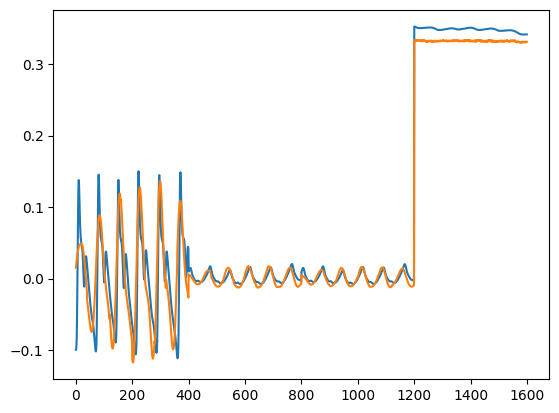

In [72]:
idx = 2456
plt.plot(PredLat[idx])
plt.plot(Pred[idx])

In [88]:
def RandZ (n=10):
    return np.concatenate([np.random.normal(0, 5, 2)[None] for i in range(n)])

RnadZ = RandZ()
RandPred = New_DecModel(RnadZ)

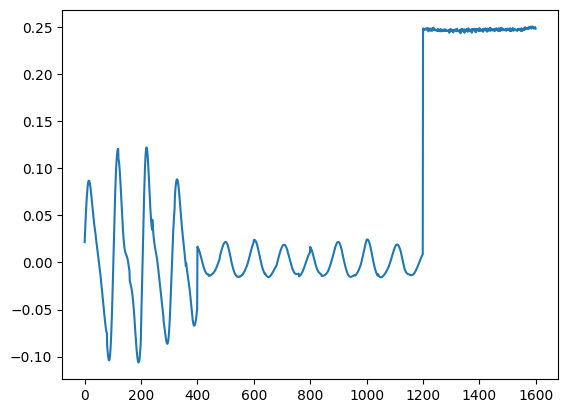

In [94]:
plt.plot(RandPred[4])

(10, 2)

In [137]:
X = np.linspace(-1, 1, 5)
Y = np.linspace(-1, 1, 5)
X_, Y_ = np.meshgrid(X,Y)
RnadZ = np.concatenate([Y_.ravel()[:,None], X_.ravel()[:,None] ],axis=-1)
RandPred = New_DecModel(RnadZ)

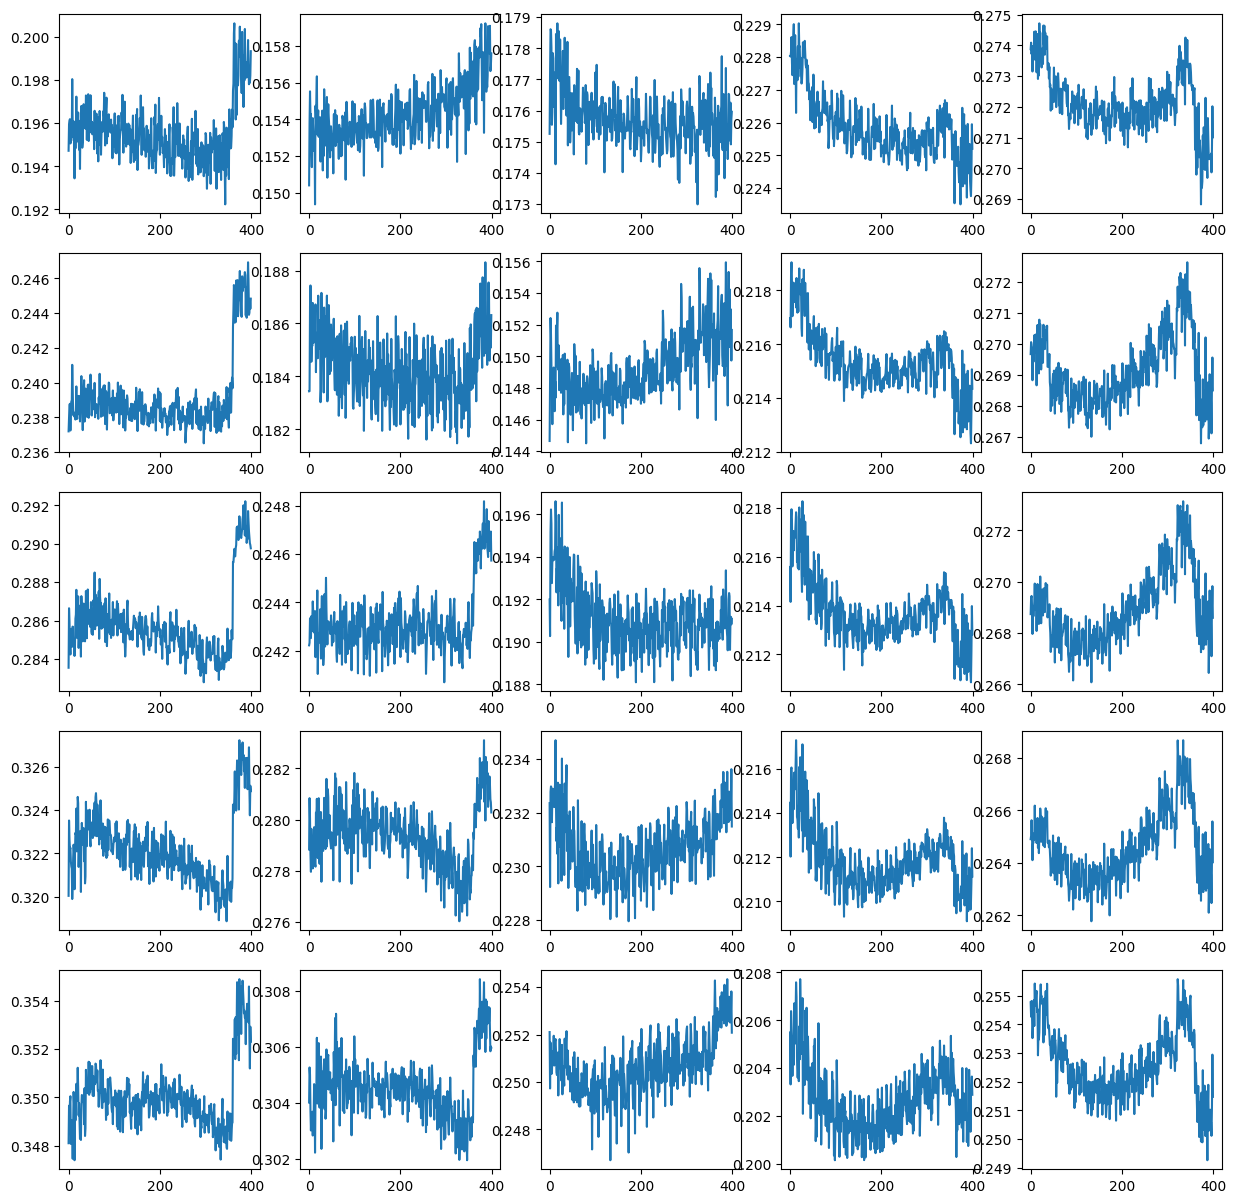

In [141]:
plt.figure(figsize=(15,15))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.plot(RandPred[i][1200:1600])
    
